In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SDDS

# inferno reversed colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
my_cmap = cm.get_cmap('inferno_r')
# my_cmap.set_under('w') # don't seem too work
xr = np.linspace(0, 1, 256)
my_cmap_listed = my_cmap(xr)
my_cmap_listed = np.vstack((np.array([np.ones(4)+(my_cmap_listed[0]-np.ones(4))*x for x in np.linspace(0,1,int(256/8))]),my_cmap_listed[:-int(256/16)]))
my_cmap = ListedColormap(my_cmap_listed)

cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.inferno_r(np.arange(255))])
colorlist=['#f3ffa0', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']
from matplotlib.ticker import FormatStrFormatter

In [2]:
def get_data(lpath, filename):
    mc2 = 0.51099895000e6
    fontsize = 22
    # load data
    ff = SDDS.readSDDS(lpath + '/' + filename)
    parameters, bunches = ff.read()
    print('number of bunches: ', bunches.shape[0],' \t particles in bunch 0: ', bunches.shape[1])
    d = bunches[0] # particle data
    return d

In [2]:
def make_plot(lpath,filename,tax = None, nbins = 200,show_current = True,
              xrange = None, tscale = 'fs', Iscale = 'kA', Escale = 'GeV', annote = None):
    mc2 = 0.51099895000e6
    fontsize = 22
    # load data
    ff = SDDS.readSDDS(lpath + '/' + filename)
    parameters, bunches = ff.read()
    print('number of bunches: ', bunches.shape[0],' \t particles in bunch 0: ', bunches.shape[1])
    d = bunches[0].T # particle data
    npart = bunches.shape[1] # number of macroparticles
    charge = parameters[0]['Charge']
  
    
    # center in time
    d[4,:] -= np.mean(d[4,:])
    
    if tscale == 'fs':
        scale = 1e15
    elif tscale == 'ps':
        scale = 1e12
        
    if Iscale == 'A':
        scale2 = 1
    elif Iscale == 'kA':
        scale2 = 1e3
    
    if Escale == 'GeV':
        scale3 = 1e9
    elif Escale == 'MeV':
        scale3 = 1e6
        
    if xrange:
        d = d[:,(d[4,:]*scale>=xrange[0])&(d[4,:]*scale<=xrange[1])]
        charge = charge*d.shape[1]/npart
        
    tt = d[4,:]
    energy = d[5,:]*mc2
    
    if not tax:
        plt.figure()
        tax = plt.gca()
    
        
    h, xedges, yedges, _ = tax.hist2d(tt*scale,energy/scale3,
                       bins = nbins,  cmap = cmap0, rasterized = True)
    tax.set_xlabel('Time (' + tscale + ')', fontsize = fontsize)
    tax.set_ylabel('Energy (' + Escale + ')', fontsize = fontsize)
    tax.tick_params(axis = 'x', labelsize = fontsize)
    tax.tick_params(axis = 'y', labelsize = fontsize)
    
    tcoords = 0.5*(xedges[1:]+xedges[:-1])
    Icoords = np.sum(h,axis=1) / np.sum(h) * charge/scale2 / np.mean(np.diff(tcoords))*scale
    
    
    
    if show_current:
        ax_I = tax.twinx()

        

        ax_I.plot(tcoords, Icoords, linewidth = 2, color = 'C0')
        ax_I.set_ylabel('Current ('+Iscale+ ')', color = 'C0', fontsize = fontsize)
        ax_I.tick_params(axis='y', colors = 'C0',labelsize = fontsize)
        
    if annote:   
        tax.annotate(annote,xy = (-0.2, 1.1), xycoords = 'axes fraction', fontsize = fontsize)
    #peak_t = tcoords[np.argmax(Icoords)]
    
    #if xlim:
    #    plt.xlim(xlim)
    #plt.show()
    #plt.close()

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    xl = lin_interp(x, y, zero_crossings_i[0], half)
    xr = lin_interp(x, y, zero_crossings_i[1], half)
    return xr - xl

number of bunches:  1  	 particles in bunch 0:  10000000


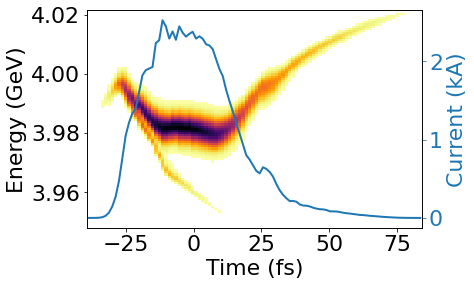

In [3]:
make_plot(lpath = './for_Nicole/tmpa205lw9v/',filename = 'SXRSTART.out' ,tax = None, nbins = 100,show_current = True,
              xrange = None, tscale = 'fs', Iscale = 'kA', Escale = 'GeV', annote = None)

In [8]:
d = get_data(lpath = './for_Nicole/tmpa205lw9v/',filename = 'SXRSTART.out')

number of bunches:  1  	 particles in bunch 0:  10000000


In [9]:
d.shape

(10000000, 8)

In [10]:
np.savetxt('./for_Nicole/tmpa205lw9v/SXRSTART.txt', d)

In [3]:
data = get_data(lpath = '/Users/nneveu/github/beam-shaping/sfg/elegant_files/joehold/100MeV/rerun_tmpa205lw9v/',filename = 'SXRSTART.out')

number of bunches:  1  	 particles in bunch 0:  10000000


In [33]:
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.units import mec2
from pmd_beamphysics.writers import *
import h5py 

In [12]:
data.shape

(10000000, 8)

In [11]:
data.size

80000000

In [13]:
tdata = data.T

In [18]:
tdata.shape[1]

10000000

In [38]:
tdata.shape

(8, 10000000)

In [24]:
#`x`, `px`, `y`, `py`, `z`, `pz`, `t`,
tdict = {}
#tdict['numParticles'] = tdata.shape[1] # number of macroparticles
tdict['species'] = 'electron'
tdict['charge'] = 1.0
tdict['x'] = tdata[0,:]
tdict['xp'] = tdata[1,:]
tdict['y'] = tdata[2,:]
tdict['yp'] = tdata[3,:]
tdict['t'] = tdata[4,:]
tdict['p'] = tdata[5,:]

In [27]:
mc2 = mec2

p =  tdict['p']*mc2
xp = tdict['xp']
yp = tdict['yp']
pz = p/np.sqrt(1 + xp**2 + yp**2)
px = xp * pz
py = yp * pz   

# number of particles
n = len(p)

status=1
pmd_data = {
    'x':tdict['x'],
    'y':tdict['y'],
    'z':np.full(n, 0),
    'px':px,
    'py':py,
    'pz':pz,
    't': tdict['t'],
    'status': np.full(n, status),
    'species':tdict['species'],
    'weight': np.full(n, abs(tdict['charge'])/n)
}


In [29]:
pdata = ParticleGroup(data=pmd_data)

In [35]:
dcns_pmd_file = h5py.File('dcns_sxr.h5', 'w')

In [36]:
write_pmd_bunch(dcns_pmd_file, pdata)

In [37]:
dcns_pmd_file.close()